In [ ]:
#install.packages(c("tidyverse", "fixest", "ggplot2", "broom"))
#install.packages("dplyr")
#install.packages("tidyr")
#install.packages("ggplot2")
#install.packages("sandwich")
#install.packages("lmtest")

Installing package into 'C:/Users/johnb/AppData/Local/R/win-library/4.5'
(as 'lib' is unspecified)



package 'dplyr' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\johnb\AppData\Local\Temp\RtmpGc22r5\downloaded_packages


Installing package into 'C:/Users/johnb/AppData/Local/R/win-library/4.5'
(as 'lib' is unspecified)



package 'tidyr' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\johnb\AppData\Local\Temp\RtmpGc22r5\downloaded_packages


Installing package into 'C:/Users/johnb/AppData/Local/R/win-library/4.5'
(as 'lib' is unspecified)



package 'ggplot2' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\johnb\AppData\Local\Temp\RtmpGc22r5\downloaded_packages


Installing package into 'C:/Users/johnb/AppData/Local/R/win-library/4.5'
(as 'lib' is unspecified)



package 'sandwich' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\johnb\AppData\Local\Temp\RtmpGc22r5\downloaded_packages


Installing package into 'C:/Users/johnb/AppData/Local/R/win-library/4.5'
(as 'lib' is unspecified)



package 'lmtest' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\johnb\AppData\Local\Temp\RtmpGc22r5\downloaded_packages


In [14]:
library(tidyverse)
library(fixest) 
library(ggplot2)
library(dplyr)

In [7]:
file_path <- "input/bacon_example.csv"
df <- read.csv(file_path)

# Preview data
head(df)

,stfips,year,X_nfd,post,asmrs,pcinc,asmrh,cases,weight,copop
,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,1964,1971,0,35.63988,12406.18,5.007341,0.012312243,1715156,1715156
2,1,1965,1971,0,41.54375,13070.21,4.425367,0.010419407,1715156,1725186
3,1,1966,1971,0,34.25233,13526.66,4.874819,0.009900097,1715156,1735219
4,1,1967,1971,0,34.46502,13918.19,5.362014,0.009974692,1715156,1745250
5,1,1968,1971,0,40.44011,14684.81,4.643759,0.012400659,1715156,1755283
6,1,1969,1971,0,42.49012,15638.88,5.296976,0.015006756,1715156,1765316


## PART A

In [9]:
twfe_model <- feols(asmrs ~ post + pcinc + asmrh + cases | stfips + year, 
                    data = df, 
                    cluster = ~stfips)

etable(twfe_model)

,,twfe_model
,<chr>,<chr>
1,Dependent Var.:,asmrs
2,,
3,post,-2.516 (2.283)
4,pcinc,-0.0011** (0.0004)
5,asmrh,1.185* (0.5765)
6,cases,-178.5 (138.0)
7,Fixed-Effects:,------------------
8,stfips,Yes
9,year,Yes


## PART B

In [ ]:
output_path <- "output_r"
if (!dir.exists(output_path)) dir.create(output_path)

# 1. Verificar y corregir nombre (Relative Time Creation - 1.5 pts)
if ("X_nfd" %in% names(df)) {
  df <- df %>% rename(nfd = X_nfd)
} else if ("_nfd" %in% names(df)) {
  df <- df %>% rename(nfd = `_nfd`) 
}

# 2. Crear variable de tiempo relativo
df <- df %>%
  mutate(event_time = year - nfd) %>%
  mutate(event_time = replace_na(event_time, -999)) # Control groups

# 3. Frequency Table (0.5 pts)
cat("--- Tabla de Frecuencias (Sin procesar) ---\n")
print(table(df$event_time))

# 4. Choosing Bounds & Binning (0.5 pts)
lower_bound <- -8
upper_bound <- 10

# JUSTIFICACIÓN (Question - 0.5 pts): 
# Esto es vital para el puntaje. Imprímelo o ponlo como comentario destacado.
cat("\n--- Justificación de Límites ---\n")
cat("Se eligieron los límites", lower_bound, "y", upper_bound, 
    "observando la tabla de frecuencias. Los periodos fuera de este rango tienen pocas observaciones,",
    "lo que causaría alta varianza. Se realiza 'binning' (acumulación) en los extremos para no perder esa data.\n")

# Aplicamos el binning (Acumular colas)
df <- df %>%
  mutate(
    rel_time_binned = case_when(
      event_time < lower_bound ~ lower_bound, # Todo lo menor a -8 se vuelve -8
      event_time > upper_bound ~ upper_bound, # Todo lo mayor a 10 se vuelve 10
      TRUE ~ event_time
    )
  )

# 5. Dummy creation (1 pt)
rel_times <- sort(unique(df$rel_time_binned))

# Excluimos referencia (t = -1) y nunca tratados (-999)
rel_times <- rel_times[rel_times != -1 & rel_times != -999]

dummy_names <- c()

for (k in rel_times) {
  # Nombres claros: rel_neg_2, rel_pos_0, etc.
  prefix <- ifelse(k < 0, "neg", "pos") 
  col_name <- paste0("rel_", prefix, "_", abs(k)) # Agregué un guion bajo extra por legibilidad
  
  # Crear dummy
  df[[col_name]] <- as.integer(df$rel_time_binned == k)
  
  dummy_names <- c(dummy_names, col_name)
}

cat("\n--- Dummies creadas exitosamente ---\n")
print(head(df[, dummy_names], 3)) # Muestra una vista previa para confirmar

--- Tabla de Frecuencias (Sin procesar) ---



-999  -21  -20  -19  -18  -17  -16  -15  -14  -13  -12  -11  -10   -9   -8   -7 
 429    1    2    2    2    2    3    3    3    6    7    9   12   22   25   32 
  -6   -5   -4   -3   -2   -1    0    1    2    3    4    5    6    7    8    9 
  34   36   36   36   36   36   36   36   36   36   36   36   36   36   36   36 
  10   11   12   13   14   15   16   17   18   19   20   21   22   23   24   25 
  36   36   35   34   34   34   34   33   33   33   30   29   27   24   14   11 
  26   27 
   4    2 

--- Justificación de Límites ---
Se eligieron los límites -8 y 10 observando la tabla de frecuencias. Los periodos fuera de este rango tienen pocas observaciones, lo que causaría alta varianza. Se realiza 'binning' (acumulación) en los extremos para no perder esa data.

--- Dummies creadas exitosamente ---
  rel_neg_8 rel_neg_7 rel_neg_6 rel_neg_5 rel_neg_4 rel_neg_3 rel_neg_2
1         0         1         0         0         0         0         0
2         0         0         1       

In [ ]:
freq_table_df <- as.data.frame(table(df$event_time))
colnames(freq_table_df) <- c("Event_Time", "Frecuencia")
full_file_name <- file.path(output_path, "tabla_frecuencias.csv")
write.csv(freq_table_df, full_file_name, row.names = FALSE)

## part c

[1] "Nombres de coeficientes detectados:"
[1] "rel_neg_8" "rel_neg_7" "rel_neg_6" "rel_neg_5" "rel_neg_4" "rel_neg_3"
[1] "Gráfico guardado en: output_r/event_study_plot.png"
[1] "CSV guardado en: output_r/event_study_coefs.csv"


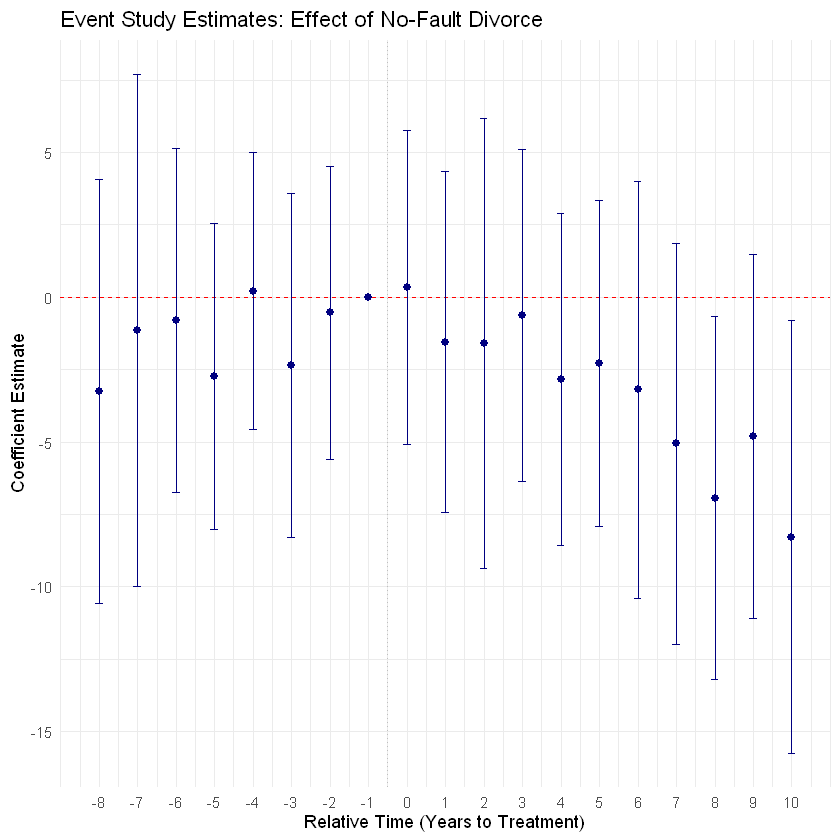

In [ ]:

# 1. Estimate the model
# ---------------------
dummy_formula <- paste(dummy_names, collapse = " + ")
formula_es <- as.formula(paste("asmrs ~", dummy_formula, "+ pcinc + asmrh + cases | stfips + year"))
model_es <- feols(formula_es, data = df, cluster = ~stfips)

# 2. Store coefficients (CORREGIDO)
# ---------------------------------
res_es <- broom::tidy(model_es, conf.int = TRUE) %>%
  filter(grepl("rel_", term)) 

# Verificamos qué nombres tenemos realmente antes de procesar (para debugging visual)
print("Nombres de coeficientes detectados:")
print(head(res_es$term))

plot_data <- res_es %>%
  mutate(
    period = term %>% 
      # Paso 1: Quitar el prefijo base "rel_"
      str_remove("rel_") %>% 
      # Paso 2: Si existe "neg_" o "neg", cambiarlo por "-"
      str_replace("neg_?", "-") %>% 
      # Paso 3: Si existe "pos_" o "pos", quitarlo (dejar vacío)
      str_remove("pos_?") %>% 
      # Paso 4: Limpiar cualquier guion bajo remanente (ej. si quedo "_2")
      str_remove("_") %>%
      # Paso 5: Convertir a número
      as.numeric()
  ) %>%
  select(period, estimate, conf.low, conf.high)

# Verificar si quedaron NAs (Esto te salvará del error en el gráfico)
if(any(is.na(plot_data$period))) {
  stop("¡Error! La conversión de nombres a periodos generó NAs. Revisa 'res_es$term'.")
}

# Add reference period (t = -1)
ref_point <- data.frame(period = -1, estimate = 0, conf.low = 0, conf.high = 0)
plot_data <- bind_rows(plot_data, ref_point) %>% arrange(period)

# 3. Plotting & Saving
# --------------------
p_es <- ggplot(plot_data, aes(x = period, y = estimate)) +
  geom_hline(yintercept = 0, color = "red", linetype = "dashed") +
  geom_vline(xintercept = -0.5, color = "grey", linetype = "dotted") +
  geom_point(color = "navy", size = 2) +
  geom_errorbar(aes(ymin = conf.low, ymax = conf.high), width = 0.2, color = "navy") +
  labs(
    title = "Event Study Estimates: Effect of No-Fault Divorce",
    x = "Relative Time (Years to Treatment)",
    y = "Coefficient Estimate"
  ) +
  scale_x_continuous(breaks = seq(min(plot_data$period), max(plot_data$period), 1)) +
  theme_minimal()

print(p_es)

# --- GUARDAR PLOT ---
file_name_plot <- file.path(output_path, "event_study_plot.png")
ggsave(filename = file_name_plot, plot = p_es, width = 8, height = 6, dpi = 300)
print(paste("Gráfico guardado en:", file_name_plot))

# --- GUARDAR CSV ---
file_name_csv <- file.path(output_path, "event_study_coefs.csv")
write.csv(plot_data, file_name_csv, row.names = FALSE)
print(paste("CSV guardado en:", file_name_csv))